In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('./datasets/cleaned-df.csv')

In [3]:
df.head()

,order_id,price,freight_value,product_name_len,product_description_len,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,order_purchase_dayofweek,days_to_customer,days_to_carrier,overall_shipping_time,shipped_on_time,delivered_on_time,category,customer_name,product_name,brand_name
0,00010242fe8c5a6d1ba2dd792cb16214,58.9,13.29,58,598,4,650.0,28.0,9.0,14.0,...,2,1.2,6.4,7.6,0,1,gifts_party,Rodrigo Keefe,limit Lisa,Speed Net Electronics
1,130898c0987d1801452a8ed92a670612,55.9,17.96,58,598,4,650.0,28.0,9.0,14.0,...,2,8.4,7.0,15.4,0,1,gifts_party,Julianna Queen,limit Lisa,Speed Net Electronics
2,532ed5e14e24ae1f0d735b91524b98b9,64.9,18.33,58,598,4,650.0,28.0,9.0,14.0,...,4,12.2,5.2,17.3,0,1,gifts_party,Palmer Bankston,limit Lisa,Speed Net Electronics
3,6f8c31653edb8c83e1a739408b5ff750,58.9,16.17,58,598,4,650.0,28.0,9.0,14.0,...,1,7.1,1.0,8.1,1,1,gifts_party,Lupe Pettigrew,limit Lisa,Speed Net Electronics
4,7d19f4ef4d04461989632411b7e588b9,58.9,13.29,58,598,4,650.0,28.0,9.0,14.0,...,3,13.0,0.9,13.9,1,1,gifts_party,Genaro Cheatham,limit Lisa,Speed Net Electronics


In [4]:
df.columns

Index(['order_id', 'price', 'freight_value', 'product_name_len',
       'product_description_len', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'seller_city', 'seller_state',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'payment_type', 'payment_installments', 'payment_value', 'review_score',
       'order_purchase_year', 'order_purchase_month',
       'order_purchase_dayofweek', 'days_to_customer', 'days_to_carrier',
       'overall_shipping_time', 'shipped_on_time', 'delivered_on_time',
       'category', 'customer_name', 'product_name', 'brand_name'],
      dtype='object')

In [5]:
col_counts = df['product_name'].value_counts()
top_50_prod = col_counts[0:50].index.to_list()

In [6]:
top_50_prod

['chick statement',
 'crayon icebreaker',
 'karate tugboat',
 'law icon',
 'utensil scallion',
 'icon tip',
 'patch cone',
 'transmission pink',
 'February Africa',
 'lamp height',
 'chin drain',
 'hand step-uncle',
 'system hockey',
 'pendulum Aquarius',
 'shake violin',
 'swim shop',
 'opinion broker',
 'freckle sundial',
 'margin balance',
 'elbow novel',
 'work fiber',
 'bagel passive',
 'trial target',
 'engine peer-to-peer',
 'attack library',
 'current feather',
 'stamp hacksaw',
 'South Korea goal',
 'daisy duck',
 'panda radio',
 'arch segment',
 'island purple',
 'shirt acoustic',
 'pendulum larch',
 'syrup icebreaker',
 'sousaphone bell',
 'garden river',
 'withdrawal straw',
 'soldier glockenspiel',
 'beer metal',
 'sweatshop moustache',
 'creature gorilla',
 'professor leaf',
 'state printer',
 'knot middle',
 'leg pentagon',
 'value freon',
 'mustard judge',
 'sun plier',
 'postbox river']

In [7]:
top_df = df.loc[df['product_name'].isin(top_50_prod)]

In [8]:
top_df.brand_name.value_counts()

Galaxy People                        1858
Network Vision Bell                   949
Pacific Star Solutions                733
Architecture Signal Consulting        731
Telecom Design Provider               634
People Vision Systems                 504
Studio Design South                   336
Medicine Galaxy Bell                  302
Advanced Universal Power              294
Software Power Bell                   272
Electronic Resource                   237
Adventure Graphics Consulting         224
Construction Medicine Advanced        193
Software Interactive Medicine         176
Resource Building People              166
Adventure Alpha Industries            152
Telecom Federated Direct              148
Source Contract Analysis              140
Vision Federated Solutions            140
Digital Network Star                  136
Omega Pacific Telecom                 135
Electronics Hardware Architecture     130
Bell East                             117
Building Architecture General     

In [11]:
column_edge = 'brand_name'
column_ID = 'product_name'

# select columns, remove NaN
data_to_merge = top_df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() 

# To create connections between people who have the same number,
# join data with itself on the 'ID' column.
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge)

In [12]:
data_to_merge.head()

,product_name,brand_name,product_name_2
0,chin drain,Network Vision Bell,chin drain
1,chin drain,Network Vision Bell,system hockey
2,chin drain,Network Vision Bell,sousaphone bell
3,chin drain,Network Vision Bell,lamp height
4,chin drain,Network Vision Bell,soldier glockenspiel


In [9]:
# By joining the data with itself, people will have a connection with themselves.
# Remove self connections, to keep only connected people who are different.
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

NameError: name 'data_to_merge' is not defined

In [10]:
d.head()

NameError: name 'd' is not defined

In [28]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=top_df.product_name.tolist(), label=top_df.product_name.tolist())

In [29]:
len(G.nodes())

8394

In [30]:
column_edge = 'product_name'
column_ID = 'customer_name'

data_to_merge = top_df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [31]:
d.head()

,customer_name,customer_name_2,product_name
4,Lila Monson,Michaela Roach,chin drain
5,Lila Monson,Robert Hopper,chin drain
8,Lila Monson,Toney Schwartz,chin drain
11,Lila Monson,Rubin Lancaster,chin drain
20,Lila Monson,Randolph Harmon,chin drain


In [34]:
edges = d.drop(columns='product_name')

In [36]:
edges.to_csv(r'/Users/elkehansen/Documents/general_assembly/Capstone-Subsmission/Elke/datasets/network_edges.csv', index=False)

In [14]:
customers = d.customer_name.unique().tolist()

In [15]:
type(customers)

list

In [16]:
len(customers)

8296

In [17]:
points = df[df['customer_name'].isin(customers)][['customer_name','category','brand_name']]

#### Ideally would like to have the network graph by product as the flourish visualisation does not allow colouring by edge (which I would like so I can see a correlation on category). HOWEVER, I just want to see what the initial graph looks like so I will just 'drop first' in duplicates so I can get something working

In [23]:
points_adj = points.drop_duplicates(subset=['customer_name'],keep='first')

In [24]:
points_adj.to_csv(r'/Users/elkehansen/Documents/general_assembly/Capstone-Subsmission/Elke/datasets/network_points.csv', index=False)


In [33]:
# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in d.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)

In [38]:
# EDGE_SIZE = {
#     'customer_unique_id': 2,
#     'seller_id': 1,
# }

# EDGE_COLOR = {
#     'customer_unique_id': 'purple',
#     'seller_id': 'red',
# }

# def clean_edge(edge):
#     s.edge[edge[0], edge[1]].values()

# def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
    
# # For nx.Graph()
# def edge_sizes(s): return [EDGE_SIZE[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one size
# def edge_colors(s): return [EDGE_COLOR[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one color

# # For nx.MultiDiGraph()
# def edge_sizes(s): return [EDGE_SIZE[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one size
# def edge_colors(s): return [EDGE_COLOR[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one color

def draw(s):
    pos = nx.spring_layout(s, scale=0.5)
    node_labels = dict((n,d['Name']) for n,d in s.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
    nx.draw(s, pos=pos, width=edge_sizes(s), edge_color=edge_colors(s), alpha=0.8, arrows=False, node_color='lightgrey', node_size=20,
#             labels=node_labels, 
#             font_color='black', font_size=8, font_weight='bold',
           )
    edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)
    nx.draw_networkx_edges

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


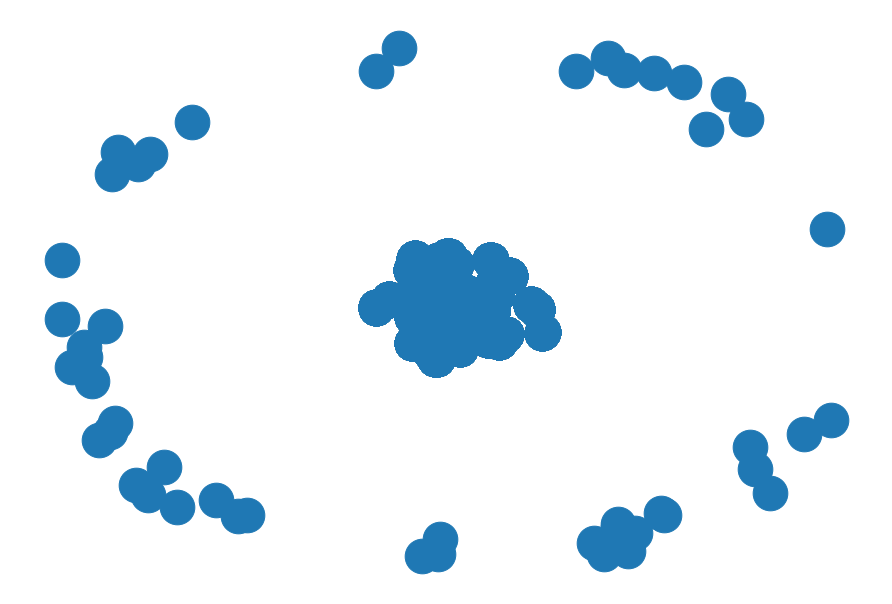

In [39]:
nx.draw(G)

In [41]:
G.number_of_edges()

898871

In [42]:
G.number_of_nodes()

8394

In [24]:
import pandas as pd
pd.options.display.max_columns = 20
import numpy as np
rng = np.random.RandomState(seed=5)
ints = rng.randint(1, 11, size=(3,2))
a = ['A', 'B', 'C']
b = ['D', 'A', 'E']
# df = pd.DataFrame(ints, columns=['weight', 'cost'])
# df[0] = a
# df['b'] = b
# df[['weight', 'cost', 0, 'b']]

G = nx.from_pandas_edgelist(df, 0, 'b', ['weight', 'cost'])


edges = pd.DataFrame({'source': [0, 1, 2],
                       'target': [2, 2, 3],
                       'weight': [3, 4, 5],
                       'color': ['red', 'blue', 'blue']})
G = nx.from_pandas_edgelist(edges, edge_attr=True)


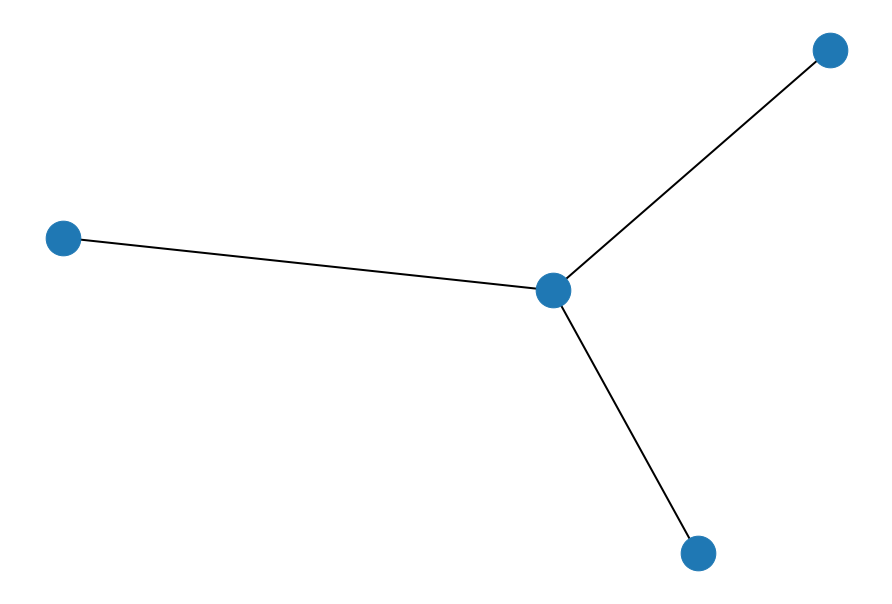

In [25]:
nx.draw(G)